In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from neuralprophet import NeuralProphet
from meteostat import Point, Daily
import optuna
import numpy as np

In [54]:
df = pd.read_csv('don_20240502_NbArrivees_vf.csv', sep=';', parse_dates=['dhreinscription'])
df = df.rename(columns={"dhreinscription": "ds", "Total": "y"})

# Douglas GPS location
montreal_weather =  Daily(Point(45.4433147,-73.5836317,17.61), df['ds'].min(), df['ds'].max())
montreal_weather = montreal_weather.fetch()
montreal_weather = montreal_weather.reset_index()

#montreal_weather.head()
df = df.merge(montreal_weather, how = 'inner', left_on='ds', right_on='time')

df = df[['ds', 'y', 'tavg','prcp']]
df = df[['ds', 'y']]

df.info()
#montreal_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3044 non-null   datetime64[ns]
 1   y       3044 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 47.7 KB


In [73]:
def objective(trial):
    params = {
        'n_lags': trial.suggest_int('n_lags', 1, 6),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 40),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 1, 5),
        'seasonality_reg': trial.suggest_float('seasonality_reg', 0.1, 100, log=True ),
        'trend_reg': trial.suggest_float('trend_reg', 0.1, 100, log=True ),
        'ar_reg': trial.suggest_float('ar_reg', 0.1, 100, log=True ),
        'newer_samples_weight': trial.suggest_float('newer_samples_weight', 1, 10, log=False),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'trend_reg_threshold': trial.suggest_categorical('trend_reg_threshold', [True, False]),
        'ar_layers': trial.suggest_categorical('ar_layers', [[], [2], [4], [6], [8], [2,2], [4, 4], [6,6], [8,8]]),
        'n_forecasts': 7,
        'epochs': 5,
        'changepoints_range': trial.suggest_float('changepoints_range', 0.8, 0.95),
        'n_changepoints': trial.suggest_int('n_changepoints', 5, 40),
        'quantiles' : [0.025, 0.975],
        'accelerator': 'auto',
        'collect_metrics': True,
        'learning_rate': 0.1
    }
    folds = NeuralProphet(**params).crossvalidation_split_df(df = df, freq="D")
    #metrics_train = pd.DataFrame(columns=METRICS)
    metrics_test = []

    for df_train, df_test in folds:
        m = NeuralProphet(**params)
        #m.set_plotting_backend("plotly-static")
        train = m.fit(df=df_train, freq="D")
        test = m.test(df=df_test, verbose=False)
        metrics_test.append(test['RMSE_val'].values[0])

    return np.mean(metrics_test)
    #return metrics_test.describe().loc[["mean", "std", "min", "max"]]

study = optuna.create_study()
study.optimize(objective, n_trials=1, n_jobs=1, show_progress_bar=True)




[I 2024-05-31 11:29:04,304] A new study created in memory with name: no-name-08761fc1-a014-48cd-9585-e471d5819bac


  0%|          | 0/1 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [] which is of type list.

WARNING - (py.warnings._showwarnmsg) - UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2] which is of type list.

WARNING - (py.warnings._showwarnmsg) - UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4] which is of type list.

WARNING - (py.warnings._showwarnmsg) - UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6] which is of type list.

WARNING - (py.warnings._showwarnmsg) - UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but con

Training: 0it [00:00, ?it/s]

[W 2024-05-31 11:29:05,975] Trial 0 failed with parameters: {'n_lags': 6, 'yearly_seasonality': 25, 'weekly_seasonality': 4, 'seasonality_reg': 9.060192500505705, 'trend_reg': 0.9359162549055785, 'ar_reg': 22.01754720134001, 'newer_samples_weight': 8.686994754045159, 'seasonality_mode': 'additive', 'trend_reg_threshold': True, 'ar_layers': [4], 'changepoints_range': 0.8403379151926451, 'n_changepoints': 25} because of the following error: RuntimeError('Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.').
Traceback (most recent call last):
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/user/1111/ipykernel_3748512/4279147677.py", line 29, in objective
    train = m.fit(df=df_train, freq="D")
            ^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...



,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,7.482333,9.004972,1.964645,0.0,0,6.807276,8.250609,1.728078,0.0
1,7.206485,8.544071,1.533869,0.0,1,6.423161,7.804814,1.410167,0.0
2,6.942252,8.063010,1.306246,0.0,2,6.057964,7.364899,1.158135,0.0
3,6.590762,7.612470,1.176149,0.0,3,5.800683,7.057987,1.025226,0.0
4,6.182940,7.152987,1.110549,0.0,4,5.411424,6.643218,0.893627,0.0
5,5.881326,6.823435,1.055640,0.0,5,5.168326,6.307647,0.808833,0.0
6,5.495310,6.488172,0.986619,0.0,6,4.742199,5.874640,0.719028,0.0
7,5.003378,6.019025,0.908391,0.0,7,4.375513,5.445921,0.635949,0.0


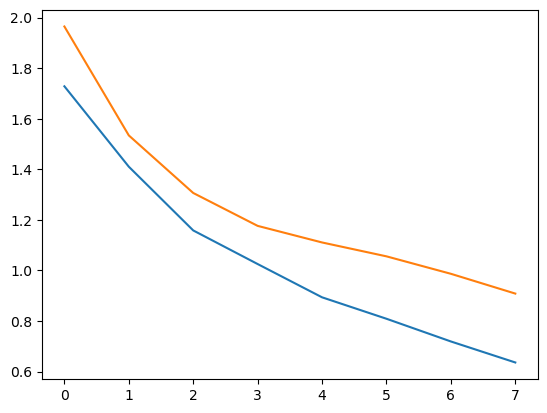

In [65]:
m = NeuralProphet(accelerator="auto",
                 collect_metrics = True,
                  trend_reg_threshold = False,
                 yearly_seasonality = 6,
                 weekly_seasonality= 3,
                 n_changepoints = 40,
                 n_forecasts = 7,
                 daily_seasonality=False,
                 quantiles=[0.025, 0.975],
                 learning_rate=0.01,
                 normalize = 'standardize',
                 epochs = 80,
                 trend_reg = 0.1,
                 seasonality_reg = 0.1,
                 changepoints_range = 0.95)
m.add_country_holidays(country_name='CA', regularization = 0.1)
m.add_seasonality(name="monthly", period=30.5, fourier_order=7)
# m.add_lagged_regressor("tavg", n_lags=14, regularization=1)
# m.add_lagged_regressor("prcp", n_lags=14, regularization=1)
df_train, df_val = m.split_df(df, valid_p=28)
metrics = m.fit(df_train, validation_df=df_val, progress="plot")
metrics